In [10]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from tqdm import tqdm
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily
from shapely.geometry import LineString
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm


In [16]:
# station demand dataset
post_covid_stations = gpd.read_file('../data/curated/stations_postcovid.gpkg')
post_covid_mean_daily_train_demand = pd.read_csv('../data/curated/train_demand/mean_daily_trains_demand_post_covid.csv')
post_covid_mean_daily_train_demand = post_covid_mean_daily_train_demand.merge(post_covid_stations[['Station_Name', 'geometry']], on = 'Station_Name')

In [73]:
# population density dataset
population = gpd.read_file('../data/POPULATION_2023_SA2_GDA2020/32180_ERP_2023_SA2_GDA2020.gpkg')
population['geometry'] = population['geometry'].to_crs('EPSG:7855')
population = population.loc[population['GCCSA_name_2021'] == 'Greater Melbourne']
population['ERP_2021'] += 1
population['density_2021'] = population['ERP_2021'] / population['Area_km2']
population['log(density_2021)'] = np.log(population['density_2021'])

In [74]:
def add_map_components(ax, bound, interval, arrow_pos=None):

    '''
        This function adds cartographic components on the map,
        including: Grid, Axes, Axes Label, North Arrow, Legends, Scale Bar
        It will be applied to every map later in the project
    '''
    # Add orientation arrow
    if arrow_pos == 'left':
        x, y, arrow_length = 0.08, 0.95, 0.1
    if arrow_pos == 'right':
        x, y, arrow_length = 0.92, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=13, xycoords=ax.transAxes)
    
    # Add axis label
    ax.annotate('Northing', xy=(-0.2,0.45),
                fontsize=11, xycoords=ax.transAxes, rotation=90)
    ax.annotate('Easting', xy=(0.45,-0.12),
                fontsize=11, xycoords=ax.transAxes)
    
    # Remove unnecessary axis
    ax.set_axis_off()

    # Make some offest to avoid map touching boundary
    # Round to create whole number axis
    xmin, ymin, xmax, ymax = bound
    xmin = np.floor(xmin / interval - 0.4) * interval
    ymin = np.floor(ymin / interval - 0.4) * interval
    xmax = np.ceil(xmax / interval + 0.4) * interval
    ymax = np.ceil(ymax / interval + 0.4) * interval
    # Generate lines for graticule
    horizontal = np.arange(np.floor(ymin), np.ceil(ymax), interval)
    vertical = np.arange(np.floor(xmin), np.ceil(xmax), interval)

    # Plot horizontal lines
    for each in horizontal:
        line = LineString([(xmin, each), (xmax, each)])
        ax.annotate(f'{int(each)}', xy=(xmin+20000, each), xytext=(-60, -5),
                    textcoords="offset points")
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)
    
    # Plot vertical lines
    for each in vertical:
        line = LineString([(each, ymin), (each, ymax)])
        ax.annotate(f'{int(each)}', xy=(each, ymin+10000), xytext=(-15, -35),
                    textcoords="offset points", rotation=45)
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)

    # Add Scale Bar
    scalebar = ScaleBar(100, 'cm', 
                        length_fraction=0.15, 
                        location='lower right', 
                        frameon=True, 
                        color='black', 
                        scale_loc='bottom', label_loc='bottom', 
                        font_properties={'size': 12})
    
    ax.add_artist(scalebar)

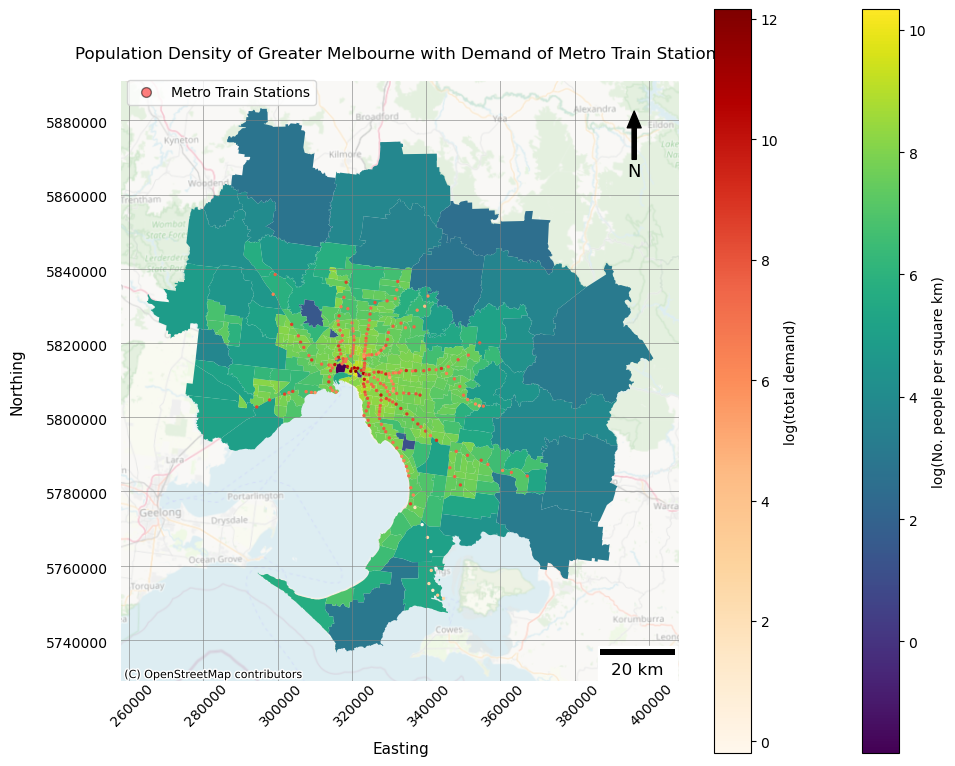

In [96]:
# Plot population density and tain demand
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
population.plot(column='log(density_2021)',
                ax=ax,
                legend=True,
                legend_kwds={'label': "log(No. people per square km)",'orientation': "vertical"})
post_covid_mean_daily_train_demand.plot(column='log_Total_Demand', 
                                        ax=ax, 
                                        legend=True,
                                        legend_kwds={'label': "log(total demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')

contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  
ax.legend(handles=legend, loc=(0.01,0.96))

add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
plt.title("Population Density of Greater Melbourne with Demand of Metro Train Stations")
plt.tight_layout()
plt.show()

In [92]:
# Read non-residential facilities
hospitals = pd.read_csv('../data/non-residential_facilities/hospitals.csv')[['Longitude', 'Latitude']]
schools = pd.read_csv('../data/non-residential_facilities/schools.csv')[['Longitude', 'Latitude']]
shopping = pd.read_csv('../data/non-residential_facilities/shopping_centre.csv')[['Longitude', 'Latitude']]
sport = pd.read_csv('../data/non-residential_facilities/sport_facilities.csv')[['Longitude', 'Latitude']]

facilities = pd.concat([hospitals, schools, shopping, sport])
facility_points = gpd.GeoDataFrame(
    facilities, 
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude)
)
facility_points.crs = 'epsg:4326'
facility_points = facility_points.to_crs("EPSG:7855")


In [93]:
# Count number of facilities per SA2
joined_df = gpd.sjoin(population, facility_points, how="left", op='intersects')
point_counts = joined_df.groupby('SA2_name_2021').size().reset_index(name='point_count')
df_facilities = population.merge(point_counts, on='SA2_name_2021', how='left')
df_facilities['point_count'].fillna(0, inplace=True) 
df_facilities['point_density'] = df_facilities['point_count'] / df_facilities['Area_km2']
df_facilities['log(point_density)'] = np.log(df_facilities['point_density'])

c:\Users\Lenovo\anaconda3\envs\spanalytics\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29712\2731608470.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_facilities['point_count'].fillna(0, inplace=True)


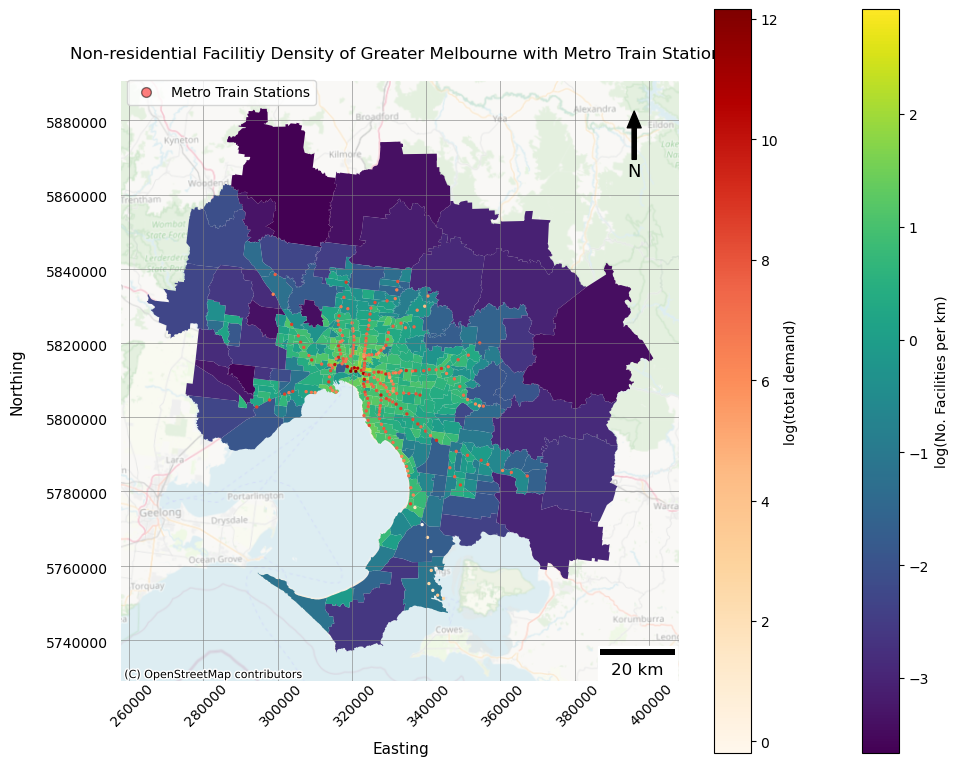

In [97]:
# Plot facilities and train demand
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
df_facilities.plot(column='log(point_density)', ax=ax, legend=True,
              legend_kwds={'label': "log(No. Facilities per km)",
                           'orientation': "vertical"})

post_covid_mean_daily_train_demand.plot(column='log_Total_Demand', 
                                        ax=ax, 
                                        legend=True,
                                        legend_kwds={'label': "log(total demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))
contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)
add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
plt.title("Non-residential Facilitiy Density of Greater Melbourne with Metro Train Stations")
plt.tight_layout()
plt.show()